<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

# Dataset and Motivation

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

*The Indeed data was scraped over ... pulling job descriptions for Data Scientists in 25 cities throughout the US. **Leo** Add Correct Details, here about the Indded data and scraper*

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Task Definition and Research Question
 
The purpose of this project was to help give a better idea of how employees at companies with open positions rate their benefits. This can help give insight into how desirable a company is as an employer.

# Literature Review

*Add -- I'm not really sure what to add here. Maybe something about turnover in data science? Companies not having great benefits?*

# Data Cleaning

In [1]:
# imports
# reading the data
import sqlite3

#data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
import re

# nltk
import nltk
from nltk.corpus import stopwords
stoplist= stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# Enable logging
import logging
logging.basicConfig(level= logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
# Initialize both tables
cnct = sqlite3.connect('Data/jobs')

indeed_df = pd.read_sql_query('SELECT * FROM indeed_jobs;', cnct)
indeed_df.drop('est salary', axis=1, inplace=True)

glassdoor_df = pd.read_sql_query('SELECT companies, type, rating, count_of_ratings FROM ratings;', cnct)

## Cleaning Indeed Data

In [3]:
# While we were able to get the estimated salary from the job scraping we can see if there was any job salaries within the job description
def salary_extract(row):
    if row['est_salary']!="No Estimated Salary":
        return row['est_salary']
    else:
        pattern = r"\$([0-9]{5,6}|[0-9]{2,3},[0-9]{3})"
        found = re.findall(pattern, row['job_desc'])
        if len(found)==1:
            return f'{found[0]} a year'
        elif len(found)>1:
            return f'{found[0]} - {found[1]} a year'
        else:
            return None

indeed_df['salary_extract'] = indeed_df.apply(salary_extract, axis=1)

In [4]:
# While we have the job title we need to categorize each job
def set_job_category(job_title):
    regex = re.compile('[^a-zA-Z]')
    clean_title = regex.sub('', job_title)
    clean_title = clean_title.lower()
    if all(x in clean_title for x in ["data", "scien"]):
        return "Data Scientist"
    elif all(x in clean_title for x in ["business", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["bi", "analy"]):
        return "Business Intelligence Analyst"
    elif all(x in clean_title for x in ["data", "analy"]):
        return "Data Analyst"
    elif all(x in clean_title for x in ["machine", "learning"]):
        return "Machine Learning Engineer"
    elif all(x in clean_title for x in ["data", "engineer"]):
        return "Data Engineer"
    elif all(x in clean_title for x in ["software", "engin"]):
        return "Software Engineer"
    elif all(x in clean_title for x in ["architect"]):
        return "Data Architect"
    else:
        return "Other"

indeed_df['job_category'] = indeed_df.loc[:, 'job_title'].apply(set_job_category)

In [5]:
# Lets get the state from the company location so we can generalize them
indeed_df.loc[:,'state'] = indeed_df.loc[:, 'company_location'].str.extract(r', ([A-Z]{2})')

In [6]:
def salary_low(row):
    if row == None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    low = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return low

def salary_high(row):
    if row ==None:
        return None
    salary = str(row).split('-')
    pattern = r'([0-9]+\.*,*[0-9]+)'
    if len(salary)>1:
        high = float(''.join(re.findall(pattern, salary[1])).replace(',',''))
    else:
        high = float(''.join(re.findall(pattern, salary[0])).replace(',',''))
    return high

indeed_df['salary_low'] = indeed_df.loc[:,'salary_extract'].apply(salary_low)
indeed_df['salary_high'] = indeed_df.loc[:,'salary_extract'].apply(salary_high)

In [7]:
# We noticed that the pay rate varies between annual, month, week, day, or hour. 
def pay_rate(row):
    if row ==None:
        return None
    regex = re.compile('[.[0-9]]')
    clean_salary = regex.sub('', row)
    clean_salary = clean_salary.lower()
    if any(x in clean_salary for x in ["year"]):
        return "annual"
    elif any(x in clean_salary for x in ["month"]):
        return "month"
    elif any(x in clean_salary for x in ["week"]):
        return "week"
    elif any(x in clean_salary for x in ["day"]):
        return "day"
    elif any(x in clean_salary for x in ["hour"]):
        return "hour"
    else:
        return "Other"

indeed_df['pay_rate'] = indeed_df.loc[:, 'salary_extract'].apply(pay_rate)

In [8]:
def calc_salary(row):
    pay_rate=row['pay_rate']
    if (pay_rate == 'Other') or (pay_rate==None):
        return None

    rate_change= {'annual':1, 'month':12, 'week':52, 'day':260, 'hour':2080}
    est_annual_salary = ((row['salary_low']+row['salary_high'])/2)*rate_change[pay_rate]
    return est_annual_salary
indeed_df['est_annual_salary'] = indeed_df.loc[:,['salary_low','salary_high','pay_rate']].apply(calc_salary, axis=1)

In [9]:
indeed_df[indeed_df['est_salary']!='No Estimated Salary'].sample(4)

,index,job_title,company_name,company_location,job_href,job_desc,est_salary,retrieve_date,salary_extract,job_category,state,salary_low,salary_high,pay_rate,est_annual_salary
11133,10,Senior Data Research Analyst,Peak Performers,"Remote in Austin, TX 78758",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Are you looking for a career with the State ...,$34 an hour,2022-03-28,$34 an hour,Data Analyst,TX,34.00,34.00,hour,70720.0
5803,0,Data Analyst - 4116949,Accenture,"Atlanta, GA",https://www.indeed.com/rc/clk?jk=9aa07201d2dd9...,Accenture Flex offers you the flexibility of l...,$34.21 - $62.83 an hour,2022-02-26,$34.21 - $62.83 an hour,Data Analyst,GA,34.21,62.83,hour,100921.6
1773,8,"Senior Data Analyst, OSC Analytics (Virtual)",Home Depot / THD,"Atlanta, GA 30301 (Buckhead area)+2 locations",https://www.indeed.com/rc/clk?jk=60bb80a32c4d4...,"POSITION PURPOSE A Senior Data Analyst, One Su...","$56,000 - $106,080 a year",2022-02-12,"$56,000 - $106,080 a year",Data Analyst,GA,56000.00,106080.00,annual,81040.0
13903,1,Variable Data Analyst,"DPI Direct, Inc.","San Diego, CA+2 locations",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,DPI Direct Inc. is Southern California’s fast...,"$68,000 - $75,000 a year",2022-04-04,"$68,000 - $75,000 a year",Data Analyst,CA,68000.00,75000.00,annual,71500.0


# Visualizations

Lets start by looking at average salary by state and job category

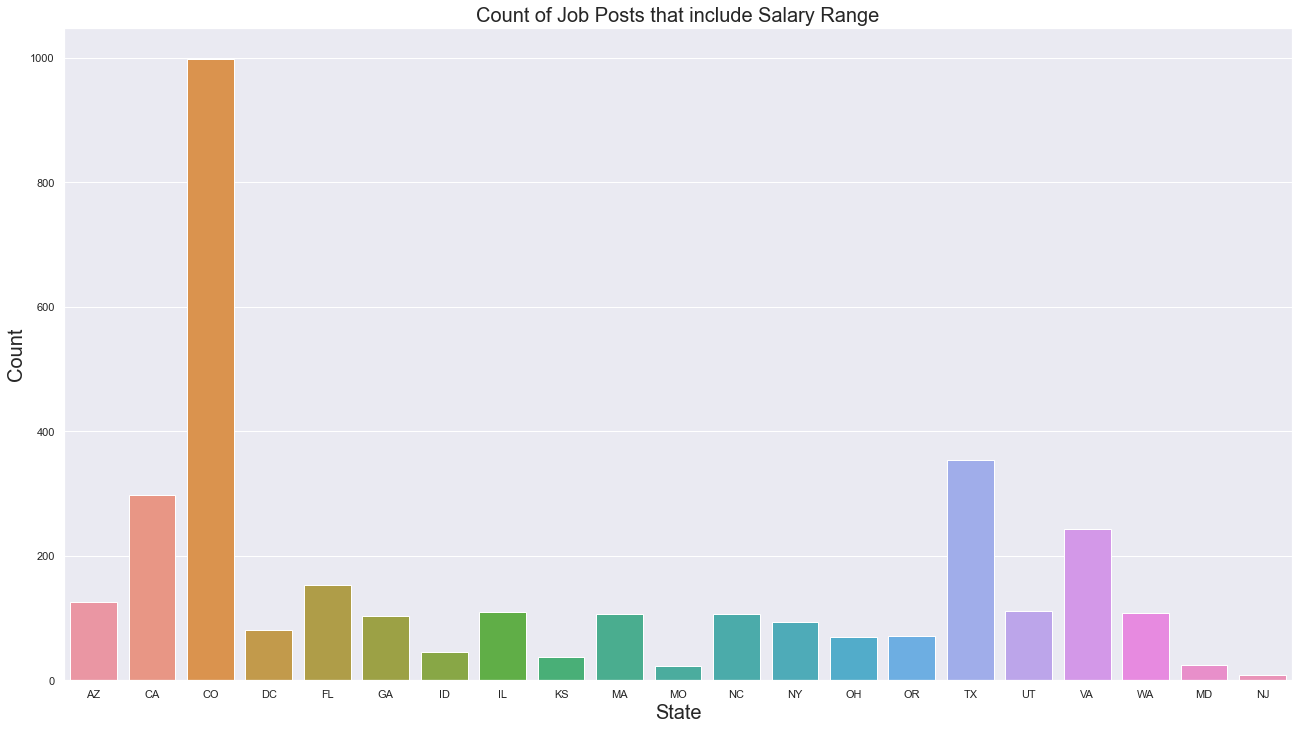

In [10]:
# Lets see what states share their salary the most
salary_by_job_state_count = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].count().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='state', y='est_annual_salary', data=salary_by_job_state_count, estimator=sum,ci=None)
plt.title('Count of Job Posts that include Salary Range',fontsize = 20)
plt.xlabel("State",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.savefig('Images/Count_of_Job_Posts_that_include_Salary_Range.png')

In [11]:
salary_by_job_state_count = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['state'])['est_annual_salary'].count().reset_index()
job_count_by_state = indeed_df[(indeed_df['job_category']!='Other')].groupby(['state'])['job_title'].count().reset_index()
jobs_joined = pd.merge(job_count_by_state, salary_by_job_state_count, how='left', on=['state'])
jobs_joined['percentage'] = jobs_joined['est_annual_salary']/jobs_joined['job_title']
jobs_joined

,state,job_title,est_annual_salary,percentage
0,AL,1,NaN,NaN
1,AZ,569,125.0,0.219684
2,CA,2037,298.0,0.146294
3,CO,1248,998.0,0.799679
4,DC,259,80.0,0.308880
5,FL,1251,153.0,0.122302
6,GA,712,103.0,0.144663
7,ID,314,45.0,0.143312
8,IL,764,110.0,0.143979
9,KS,179,37.0,0.206704


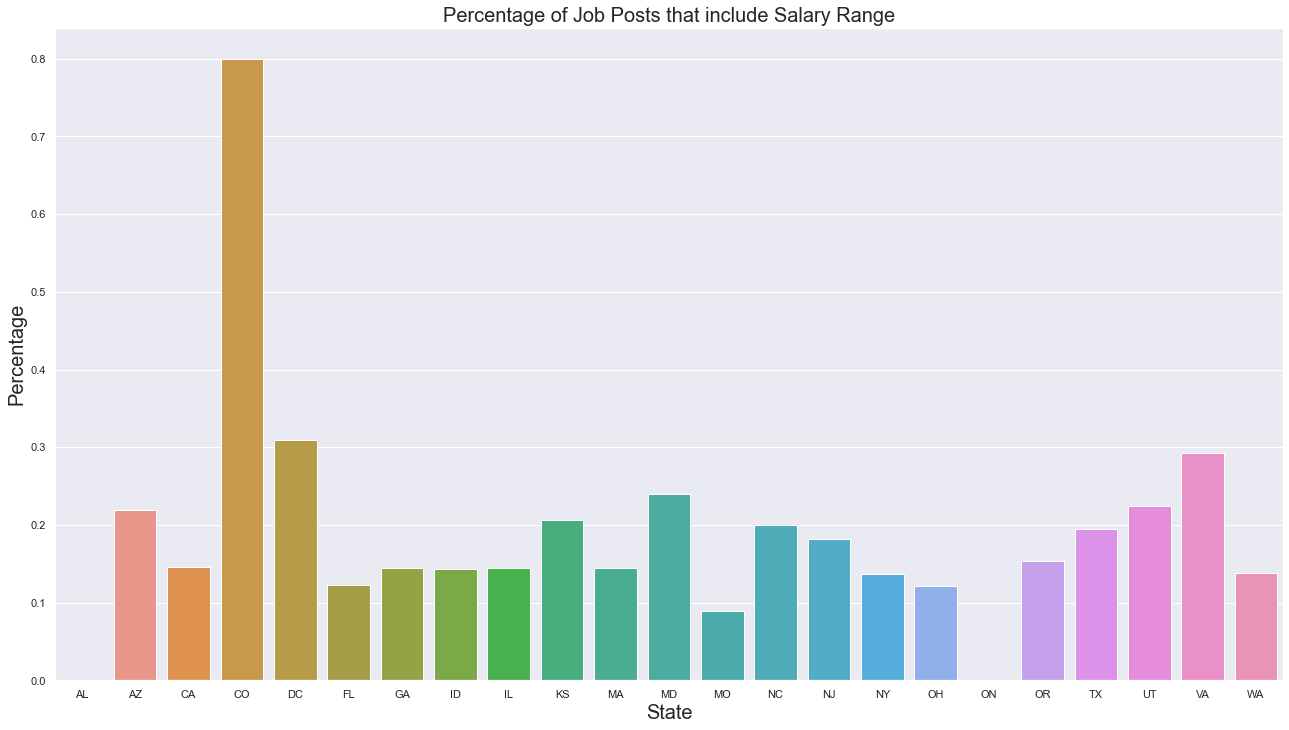

In [12]:
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='state', y='percentage', data=jobs_joined,ci=None)
plt.title('Percentage of Job Posts that include Salary Range',fontsize = 20)
plt.xlabel("State",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.savefig('Images/Perc_of_Job_Posts_that_include_Salary_Range.png')

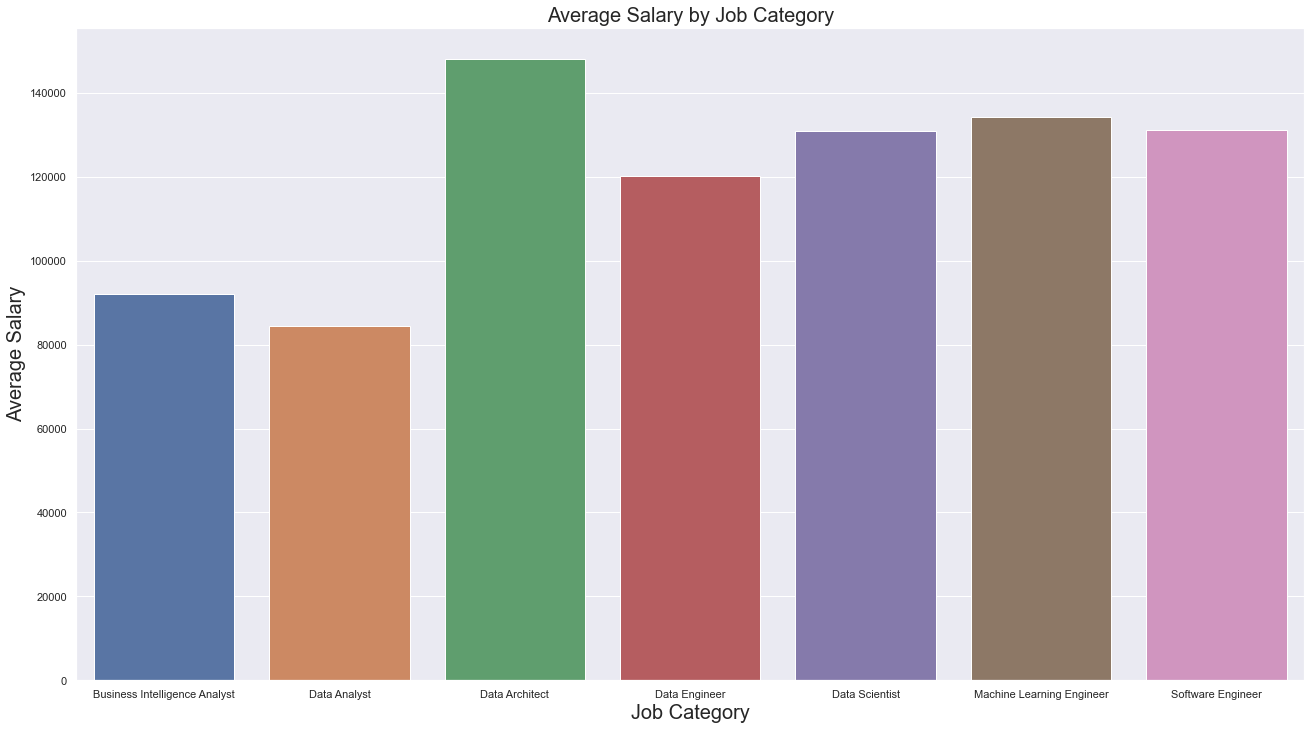

In [13]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(22,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', data=salary_by_job_state_mean)
plt.title('Average Salary by Job Category',fontsize = 20)
plt.xlabel("Job Category",fontsize=20)
plt.ylabel("Average Salary",fontsize=20)
plt.savefig('Images/Average_Salary_by_Job_Category.png')

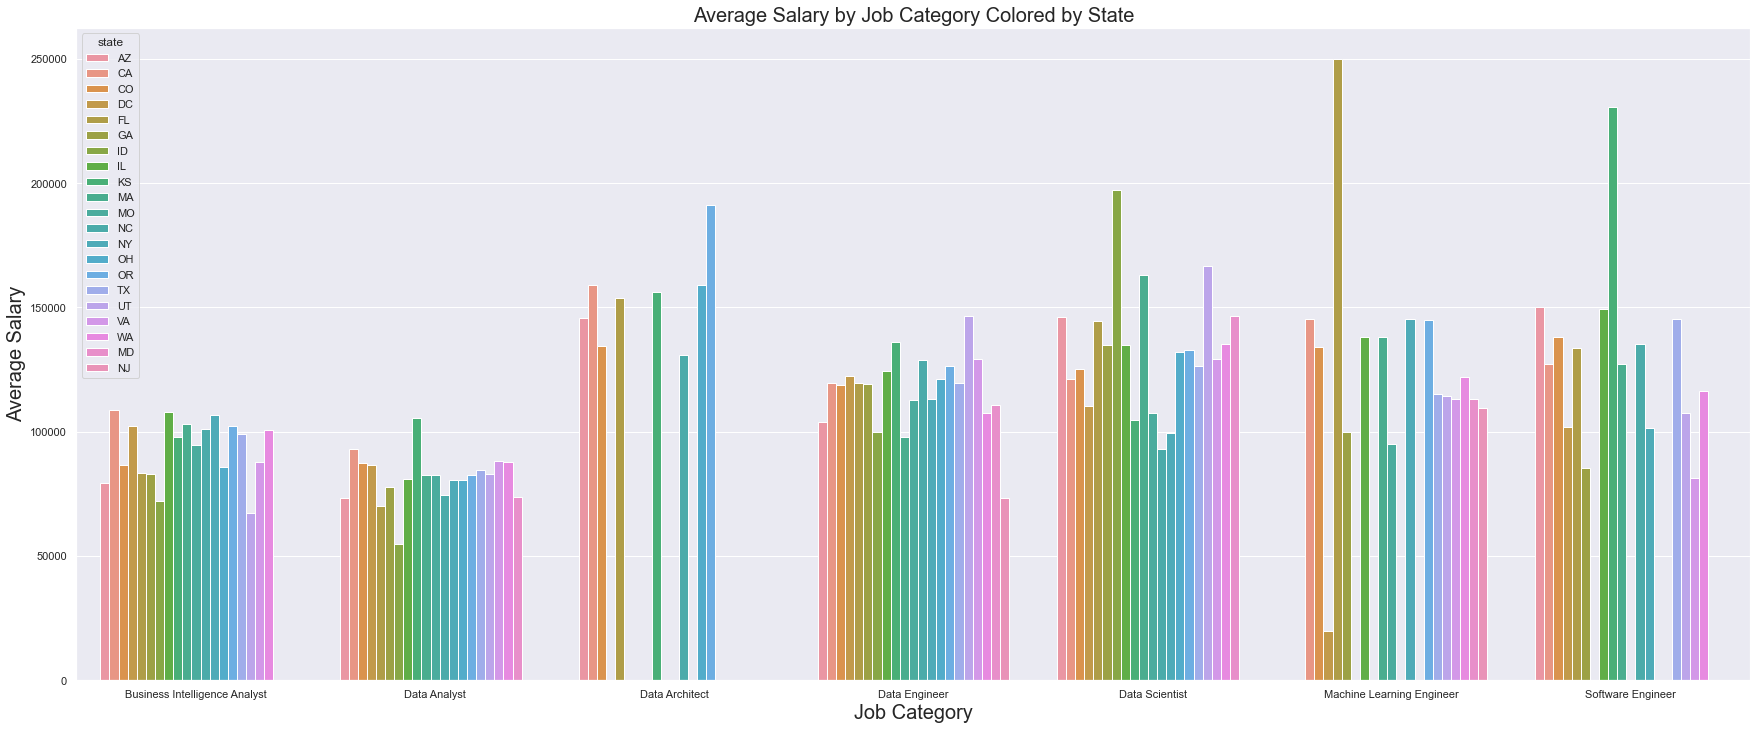

In [14]:
salary_by_job_state_mean = indeed_df[((indeed_df['job_category']!='Other')&(indeed_df['est_annual_salary']>0))].groupby(['job_category', 'state'])['est_annual_salary'].mean().reset_index()
sns.set(rc={'figure.figsize':(30,12)})
ax = sns.barplot(x='job_category', y='est_annual_salary', hue='state', data=salary_by_job_state_mean)
plt.title('Average Salary by Job Category Colored by State',fontsize = 20)
plt.xlabel("Job Category",fontsize=20)
plt.ylabel("Average Salary",fontsize=20)
plt.savefig('Images/Average_Salary_by_Job_Category_by_State.png')

### Natural Language Processing (NLP)

In [15]:
# Taking a sample of the indeed_df of the initial job cetegories that we were interested in
sample_df = indeed_df[indeed_df.job_category.isin(['Data Scientist', 'Data Analyst', 'Machine Learning Engineer', 'Data Engineer','Business Intelligence Analyst', 'Data Architect'])].copy()

In [16]:
# Drop any rows where job description is blank
indeed_df.dropna(subset=['job_desc'], inplace=True)

# Taking a sample of the indeed_df of the initial job cetegories that we were interested in
sample_df = indeed_df[indeed_df.job_category.isin(['Data Scientist', 'Data Analyst', 'Machine Learning Engineer', \
                        'Data Engineer','Business Intelligence Analyst', 'Data Architect'])].copy()

# Expand our stoplist
stoplist = ["year", "experience", "opportunity", "employer", "sexual", "orientation", "national", "origin"\
        "veteran", "status", "work", "race", "color", "religion", "orientation", "gender", "regard", "this", "position"\
        "related", "field", "closely", "with", "disability", "federal", "state", "local", "more", "than",\
        "receive", "equal", "opportunity", "veteran", "protect", "employment", "consideration", "accommodation",\
        "role", "employee", "benefit", "applicant", "such","what", "their", "company", "understand", "their",\
        "what", "minimum", "please", "which", "and/or", "vaccine", "vaccination", "understand", "their", "about", "what", \
        "write", "within", "and/or", "qualify", "prefer", "policy", "vaccination", "vaccine", "time", "qualification", \
        "qualify", "be", "without", "want", "prefer", "through", "like", "within", "inclusive", "inclusion", "organization",\
        "leave", "base", "package", "bring", "must", "candidate",  "without", "diversity", ] \
    + [word.lower() for company in indeed_df.company_name.unique() for word in company.split(' ')] \
    + [word.lower() for category in indeed_df.job_category.unique() for word in category.split(' ')] \
    + [word.lower() for title in indeed_df.job_title.unique() for word in title.split(' ')]


In [17]:
def preprocess(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """   
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
    doc_words= [word for word in doc_words if word not in stoplist]
    doc_words=[wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    stemmer=nltk.stem.PorterStemmer()
    doc_words=[stemmer.stem(word) for word in doc_words]
    
    return doc_words

job_desc_df_clean = sample_df['job_desc'].apply(preprocess)

    # Lemmatize    
    # pos_tags=nltk.pos_tag(word_tokens)
#     print(pos_tags)
    # doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]

UnboundLocalError: local variable 'doc_words' referenced before assignment

In [355]:
sample_df[sample_df.job_category!='Data Architect'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184,
            17185],
           dtype='int64', length=14061)

In [356]:
target_job_descs = job_desc_df_clean[sample_df[sample_df.job_category!='Data Architect'].index]

## Implementing TF-IDF

In [358]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8,
                                min_df=5,
                                ngram_range = (1,3),
                                stop_words = "english"

                            )

cleaned_docs = [" ".join(doc) for doc in job_desc_df_clean]
vectors = vectorizer.fit_transform(cleaned_docs)

In [359]:
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

In [360]:
all_keywords = []
for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

## Implementing K-means

In [361]:
true_k = 5
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

In [362]:
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [364]:
i = 0
for cluster in order_centroids:
    print (f"Cluster {i}")
    print([terms[keyword] for keyword in cluster[0:20]])
    # for keyword in cluster[0:15]:
    #     print (terms[keyword])
    # print ("")
    i=i+1

Cluster 0
['requir', 'includ', 'provid', 'applic', 'need', 'reason', 'protect', 'skill', 'vaccin', 'consid', 'qualifi', 'develop', 'request', 'respons', 'commit', 'individu', 'creat', 'stakehold', 'help', 'use']
Cluster 1
['skill', 'problem', 'develop', 'solv', 'use', 'includ', 'techniqu', 'drive', 'provid', 'statist', 'requir', 'stakehold', 'relat', 'identifi', 'prefer', 'need', 'demonstr', 'help', 'analyz', 'respons']
Cluster 2
['prefer', 'includ', 'develop', '000', 'use', 'implement', 'respons', 'requir', 'descript', 'relat', 'skill', 'maintain', 'build', 'provid', 'bachelor', 'design', 'look', 'larg', 'improv', 'need']
Cluster 3
['help', 'build', 'make', 'includ', 'skill', 'need', 'look', 'provid', 'develop', 'creat', 'deliv', 'use', 'drive', 'join', 'cultur', 'everi', 'commit', 'passion', 'better', 'learn']
Cluster 4
['requir', 'skill', 'provid', 'includ', 'relat', 'ensur', 'duti', 'respons', 'develop', 'maintain', 'assist', 'assign', 'need', 'analyz', 'identifi', 'function', 'mee

In [314]:
kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

In [317]:
colors = ["r", "b", "y", "c", "g"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

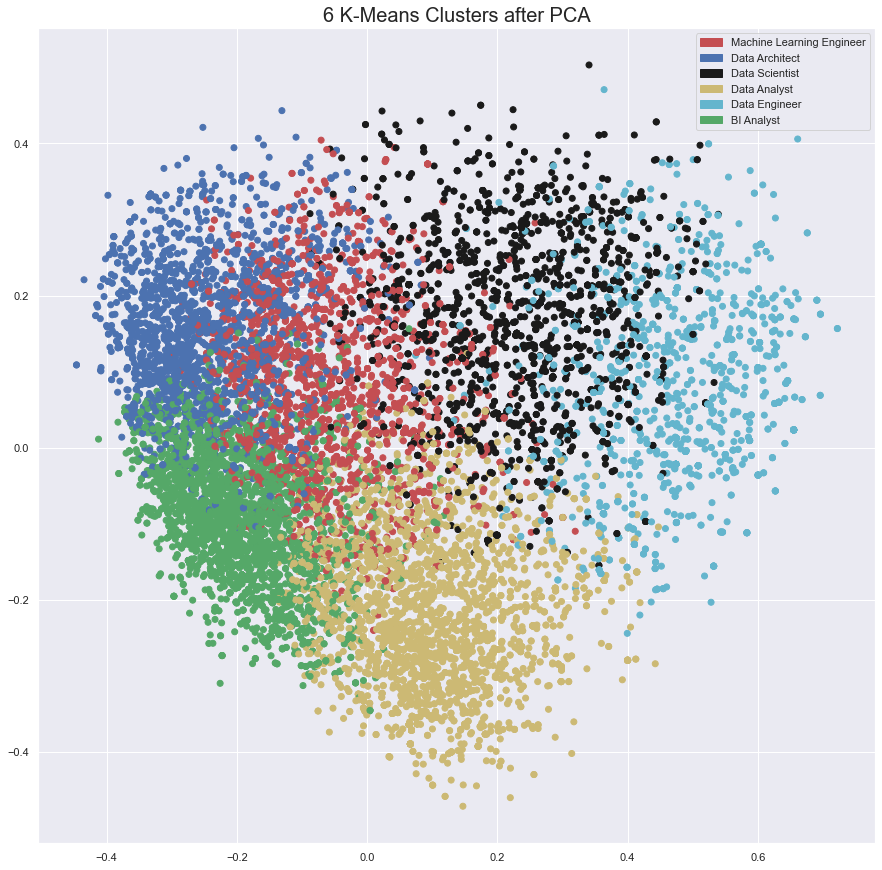

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])
clust0 = mpatches.Patch(color='r', label='Machine Learning Engineer')
clust1 = mpatches.Patch(color='b', label='Data Architect')
clust2 = mpatches.Patch(color='', label='Data Scientist')
clust3 = mpatches.Patch(color='y', label='Data Analyst')
clust4 = mpatches.Patch(color='c', label='Data Engineer')
clust5 = mpatches.Patch(color='g', label='BI Analyst')
plt.legend(handles=[clust0,clust1,clust2,clust3,clust4,clust5])
plt.title('6 K-Means Clusters after PCA',fontsize = 20)
plt.savefig('Images/6_KMeansClustersAfterPCA.png')

In [ ]:
sample_df['kmeans_cluster'] = kmean_indices

In [ ]:
job_category_dict = {0:'Machine Learning Engineer', 1:'Data Architect', 2:'Data Scientist', 3:'Analyst', 4:'Data Engineer', 5:'Analyst'}
sample_df = sample_df.replace({'kmeans_cluster':job_category_dict})

In [ ]:
job_category_dict = {'Machine Learning Engineer':'Machine Learning Engineer', 'Data Architect':'Data Architect', 'Data Scientist':'Data Scientist', 'Data Analyst':'Analyst', 'Data Engineer':'Data Engineer', 'Business Intelligence Analyst':'Analyst'}
sample_df['combined_job_category']= sample_df['job_category'].map(job_category_dict)

In [4]:
sample_df.head()

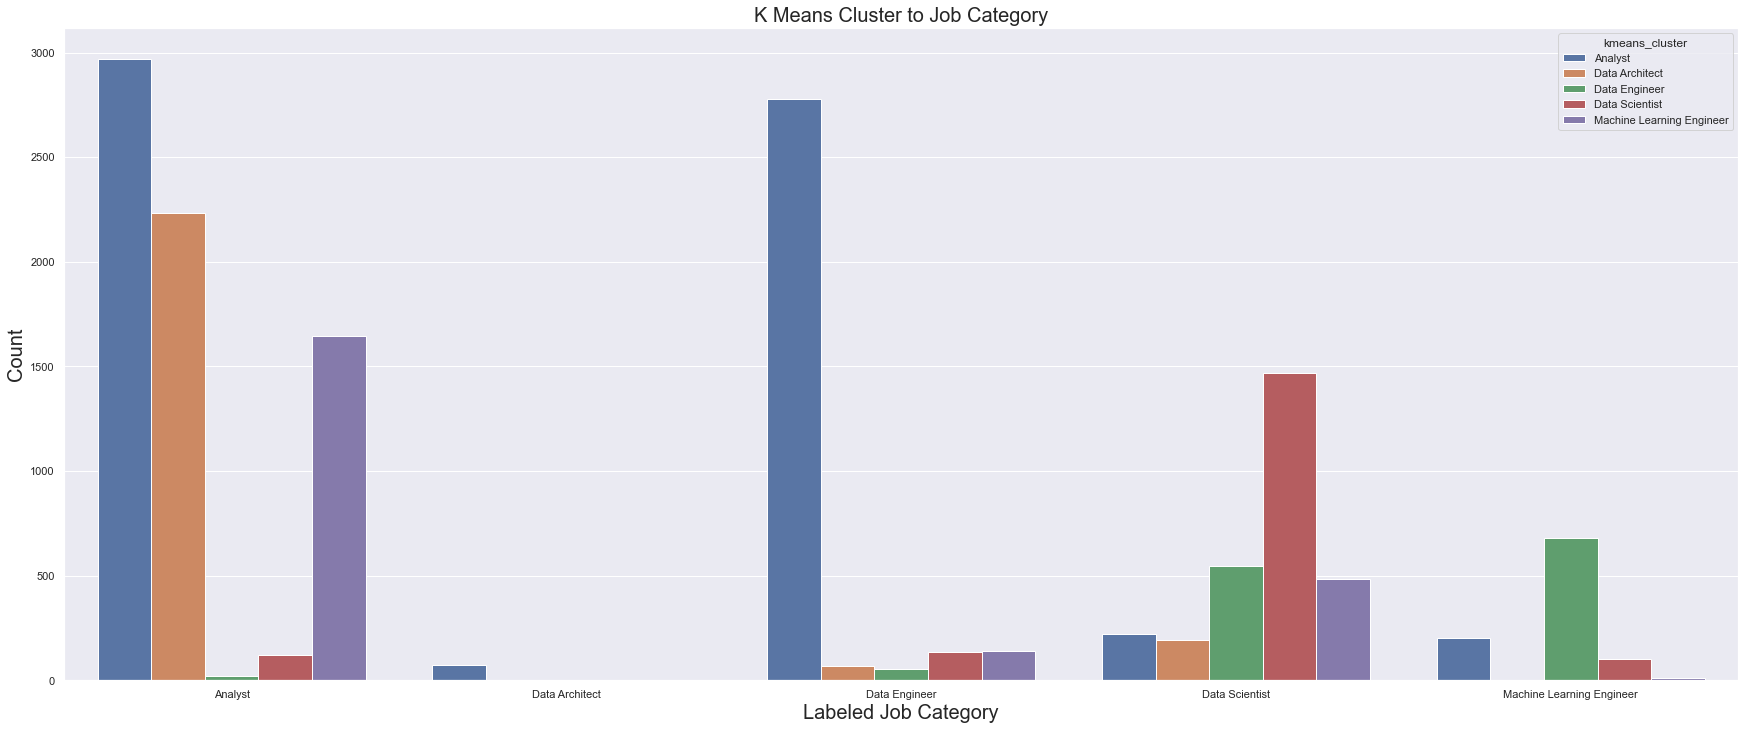

In [348]:
salary_by_job_state_mean = sample_df.loc[:,['kmeans_cluster','combined_job_category','job_title']].groupby(['combined_job_category', 'kmeans_cluster'])['job_title'].count().reset_index()
sns.set(rc={'figure.figsize':(30,12)})
ax = sns.barplot(x='combined_job_category', y='job_title', hue='kmeans_cluster', data=salary_by_job_state_mean)
plt.title('K Means Cluster to Job Category',fontsize = 20)
plt.xlabel("Labeled Job Category",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.savefig('Images/KMeansClustertoJobCategory.png')

Below is the LDA information but couldn't get too much insight form it

# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec

<!-- docs= list(target_job_descs)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(docs)
# Checkout most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stoplist:
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(15):
    print(key,">>>>", counts)
dictionary= Dictionary(data_words_bigrams)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
from gensim.models.ldamulticore import LdaMulticore

t0= time.time()
passes= 30
np.random.seed(1) # setting up random seed to get the same results
ldamodel= LdaMulticore(corpus, 
                    id2word=dictionary, 
                    num_topics=5, 
#                   alpha='asymmetric', 
                    chunksize= 4000, 
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)                    

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")
ldamodel.show_topics(num_words=30, formatted=False)
lda_corpus= ldamodel[corpus]
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
p
# stopwords to add "understand", "their", "about", "what", "write", "within", "and/or", "qualify", "prefer", "policy", "vaccination", "vaccine", "time", "qualification", "qualify", "be", "without", "want", "prefer", "through", "like", "within" --> -->